<a href="https://colab.research.google.com/github/RMCV-Rajapaksha/TeamInception_Datathon/blob/Layanga/task2_eda_and_data_preprocessing_holtwintes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1 Notebook for "insert model name here"


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Imports and Setup

**Import the Libararies**


In [54]:
import pandas as pd
import os
import numpy as np
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error

### Connecting to Google Drive

In [4]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Reading data set files

In [5]:
# Developers please update the paths according to were in your google you place datasets
# i recommend making Rootcode-ML folder and in it Datasets folder and placing the csv files there then you wont have to change below code block
bookings_data = pd.read_csv('/content/drive/MyDrive/datathon_rootcode/dataset/bookings_train.csv')
tasks_data = pd.read_csv('/content/drive/MyDrive/datathon_rootcode/dataset/tasks.csv')
staffing_data = pd.read_csv('/content/drive/MyDrive/datathon_rootcode/dataset/staffing_train.csv')

In [6]:
bookings_data.head()

,booking_id,citizen_id,booking_date,appointment_date,appointment_time,check_in_time,check_out_time,task_id,num_documents,queue_number,satisfaction_rating
0,f7b59ba3793fea61282cb02be2247cebd0a75306,4229044420,2021-01-01,2021-01-01,09:03,2021-01-01 09:11:00,2021-01-01 09:48:15.166353269,TASK-002,0,2,4
1,cfe30d53b4b645e4cb6b114f6c9d74a0f25e6a80,5389442635,2021-01-01,2021-01-01,09:12,2021-01-01 09:24:00,2021-01-01 10:24:12.189261137,TASK-001,1,1,4
2,0fb0a5d9b3944dd743a9e7828dc03fa74aa6ebf8,2123783919,2021-01-01,2021-01-01,09:36,2021-01-01 09:29:00,2021-01-01 10:26:48.802260864,TASK-002,1,6,5
3,d4bf826153212fa325ad98b215668ab942365607,6359918966,2021-01-01,2021-01-01,09:45,2021-01-01 10:07:00,2021-01-01 11:00:13.485642822,TASK-001,1,4,4
4,ebb4c9687acbaf65376d8e379bd1341d1c15127e,178732202,2021-01-01,2021-01-01,10:12,2021-01-01 10:26:00,2021-01-01 11:54:53.260180213,TASK-002,1,8,3


## EDA


### EDA of Bookings data

lets take a look at the columns and some of their values

In [7]:
staffing_data.head()

,date,section_id,employees_on_duty,total_task_time_minutes
0,2021-01-01,SEC-001,1,834.569483
1,2021-01-01,SEC-002,4,1525.368990
2,2021-01-01,SEC-003,2,662.095279
3,2021-01-01,SEC-004,4,1499.112620
4,2021-01-01,SEC-005,3,1238.533073


In [8]:
staffing_data.describe()

,employees_on_duty,total_task_time_minutes
count,5802.000000,5802.000000
mean,4.458807,1662.296769
std,2.794417,1147.134643
min,1.000000,91.109596
25%,3.000000,859.104314
50%,4.000000,1358.176924
75%,6.000000,2123.936358
max,26.000000,10658.173092


removing unnecessary columns. We wont need the total_task_time_minutes because this data wont be provided as input from the test datasets. We need the date and section_id  because they will be to calculate the actual target value (the thing to be predicted) for task 2.

In [9]:
staffing_data = staffing_data.drop(['total_task_time_minutes'],axis=1)

now lets look at the new table headers again.


In [10]:
staffing_data.head()

,date,section_id,employees_on_duty
0,2021-01-01,SEC-001,1
1,2021-01-01,SEC-002,4
2,2021-01-01,SEC-003,2
3,2021-01-01,SEC-004,4
4,2021-01-01,SEC-005,3


lets get a better idea of how null values have been distributed amoung the columns

In [11]:
staffing_data.isna().sum()

,0
date,0
section_id,0
employees_on_duty,0


## Data Preprocessing


### Rearrangement and processing of columns

### Dataset seperation according to section_id

In [12]:
task_counts = staffing_data.groupby("section_id").size().reset_index(name="count")
task_counts

,section_id,count
0,SEC-001,967
1,SEC-002,967
2,SEC-003,967
3,SEC-004,967
4,SEC-005,967
5,SEC-006,967


In [13]:
sec_1_data = staffing_data[staffing_data['section_id'] == 'SEC-001'].copy()
sec_2_data = staffing_data[staffing_data['section_id'] == 'SEC-002'].copy()
sec_3_data = staffing_data[staffing_data['section_id'] == 'SEC-003'].copy()
sec_4_data = staffing_data[staffing_data['section_id'] == 'SEC-004'].copy()
sec_5_data = staffing_data[staffing_data['section_id'] == 'SEC-005'].copy()
sec_6_data = staffing_data[staffing_data['section_id'] == 'SEC-006'].copy()


In [14]:
sec_6_data.head()

,date,section_id,employees_on_duty
5,2021-01-01,SEC-006,11
11,2021-01-04,SEC-006,6
17,2021-01-05,SEC-006,5
23,2021-01-06,SEC-006,10
29,2021-01-07,SEC-006,5


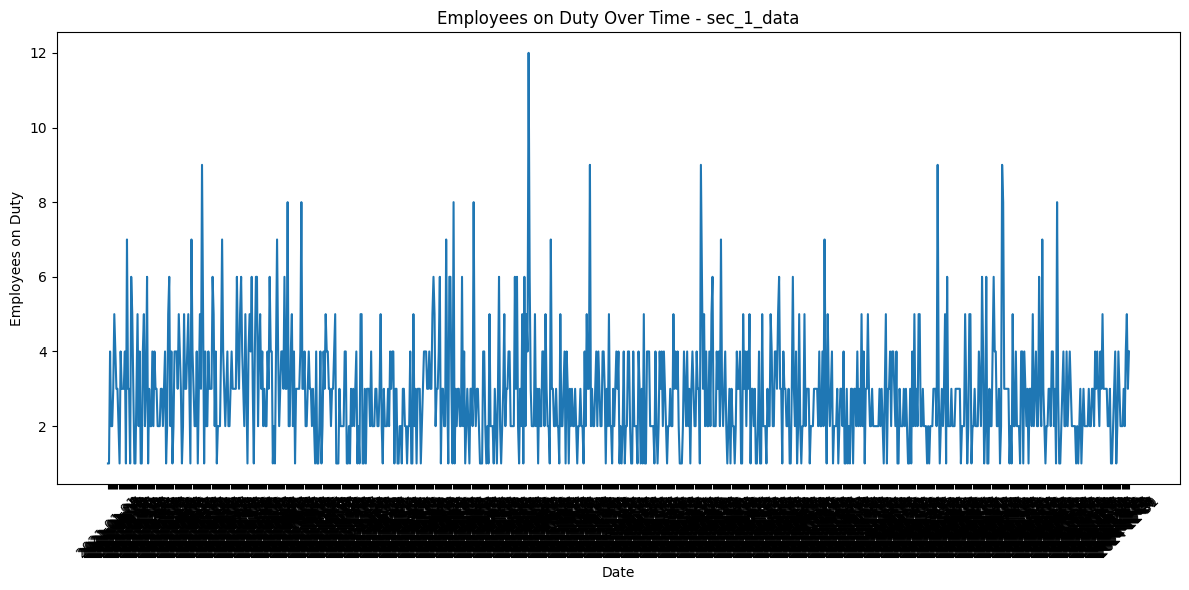

In [15]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=sec_1_data, x='date', y='employees_on_duty')
plt.title('Employees on Duty Over Time - sec_1_data')
plt.xlabel('Date')
plt.ylabel('Employees on Duty')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

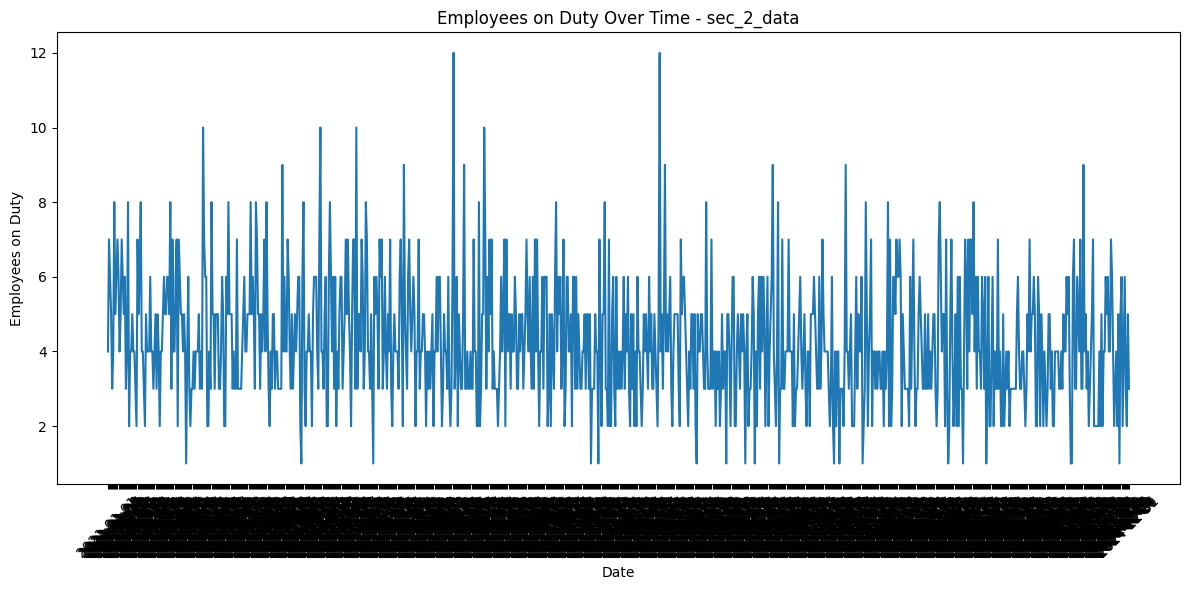

In [16]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=sec_2_data, x='date', y='employees_on_duty')
plt.title('Employees on Duty Over Time - sec_2_data')
plt.xlabel('Date')
plt.ylabel('Employees on Duty')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

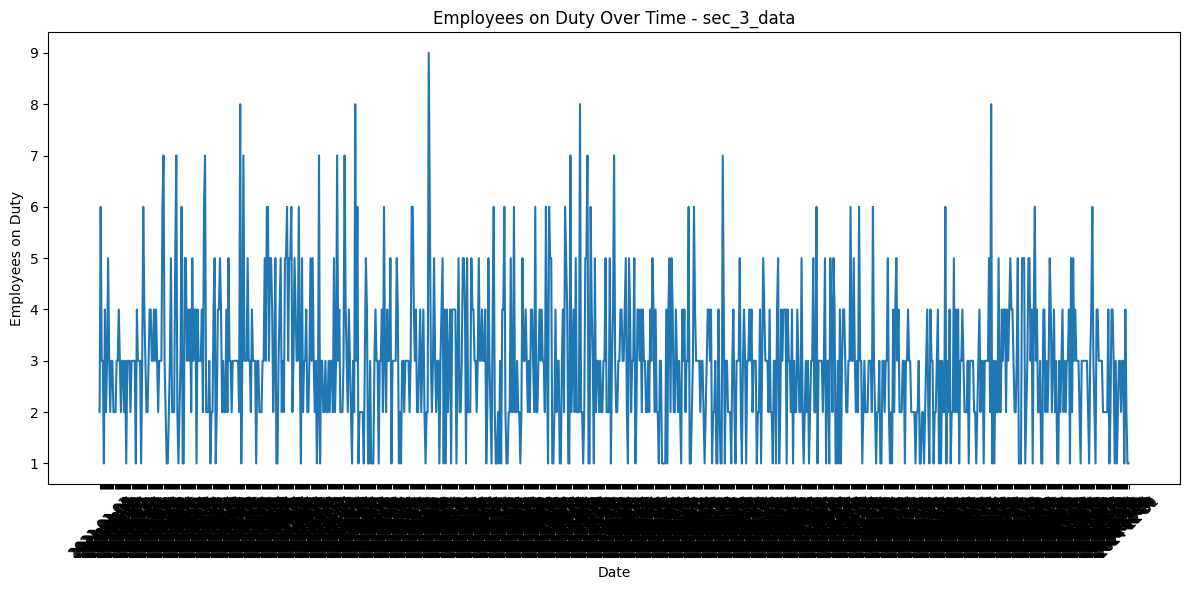

In [17]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=sec_3_data, x='date', y='employees_on_duty')
plt.title('Employees on Duty Over Time - sec_3_data')
plt.xlabel('Date')
plt.ylabel('Employees on Duty')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

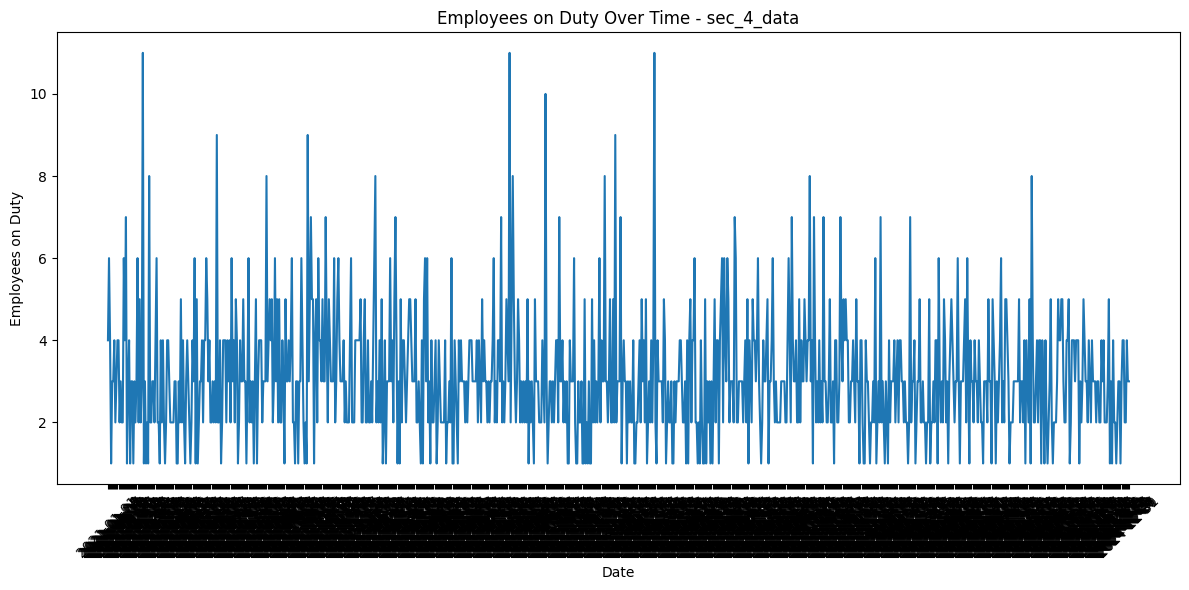

In [18]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=sec_4_data, x='date', y='employees_on_duty')
plt.title('Employees on Duty Over Time - sec_4_data')
plt.xlabel('Date')
plt.ylabel('Employees on Duty')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

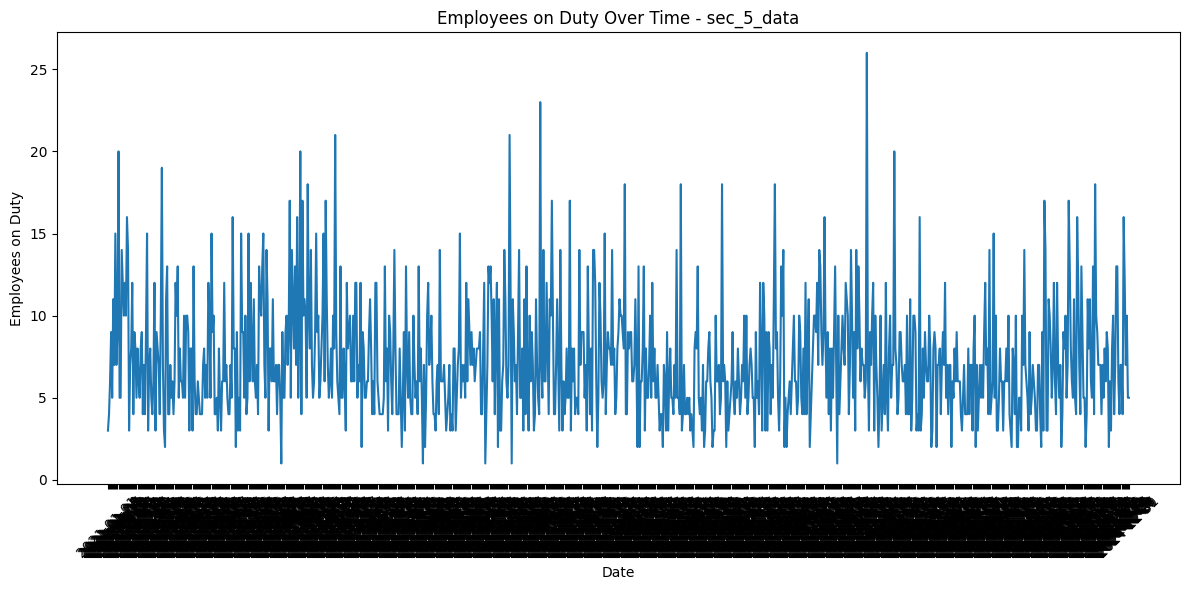

In [19]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=sec_5_data, x='date', y='employees_on_duty')
plt.title('Employees on Duty Over Time - sec_5_data')
plt.xlabel('Date')
plt.ylabel('Employees on Duty')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

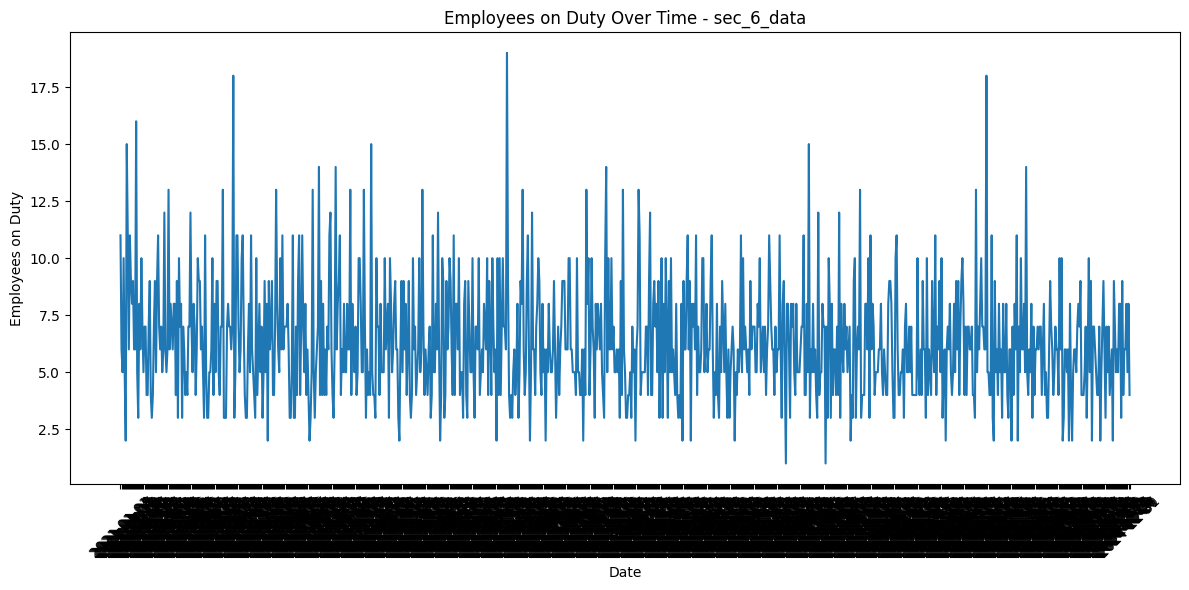

In [20]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=sec_6_data, x='date', y='employees_on_duty')
plt.title('Employees on Duty Over Time - sec_6_data')
plt.xlabel('Date')
plt.ylabel('Employees on Duty')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [43]:
df=pd.DataFrame(sec_1_data)

# Convert date to datetime
df['date'] = pd.to_datetime(df['date'])

# Sort data
df = df.sort_values('date').reset_index(drop=True)

# Quick look
print(df.head())

        date section_id  employees_on_duty
0 2021-01-01    SEC-001                  1
1 2021-01-04    SEC-001                  1
2 2021-01-05    SEC-001                  4
3 2021-01-06    SEC-001                  2
4 2021-01-07    SEC-001                  2


In [44]:
# Set date as index and ensure daily frequency
df = df.set_index("date").asfreq("D")

# Fill missing values (if any)
if df['employees_on_duty'].isnull().sum() > 0:
    df['employees_on_duty'] = df['employees_on_duty'].interpolate()

In [45]:
scaler = MinMaxScaler(feature_range=(0, 1))
df['scaled'] = scaler.fit_transform(df[['employees_on_duty']])

In [46]:
# 80/20 Train-Test Split

split_idx = int(len(df) * 0.8)
train = df.iloc[:split_idx]
test = df.iloc[split_idx:]

print(f"Train size: {len(train)}, Test size: {len(test)}")

Train size: 1168, Test size: 293


In [47]:
# Holt-Winters Model (on scaled data)

model = ExponentialSmoothing(
    train['scaled'],
    trend="add",
    seasonal="add",
    seasonal_periods=7
)

In [48]:
fit = model.fit(optimized=True)

In [49]:
# Forecast for test period
forecast_scaled = fit.forecast(len(test))

In [50]:
# Inverse scale forecast back to original employee counts
forecast = scaler.inverse_transform(forecast_scaled.values.reshape(-1, 1)).flatten()

# Inverse scale actual test values for fair comparison
test_actual = scaler.inverse_transform(test['scaled'].values.reshape(-1, 1)).flatten()

In [55]:
# Evaluate
rmse = np.sqrt(mean_squared_error(test_actual, forecast))
mae = mean_absolute_error(test_actual, forecast)

print(f"Test RMSE: {rmse:.2f}")
print(f"Test MAE: {mae:.2f}")

Test RMSE: 1.49
Test MAE: 0.95


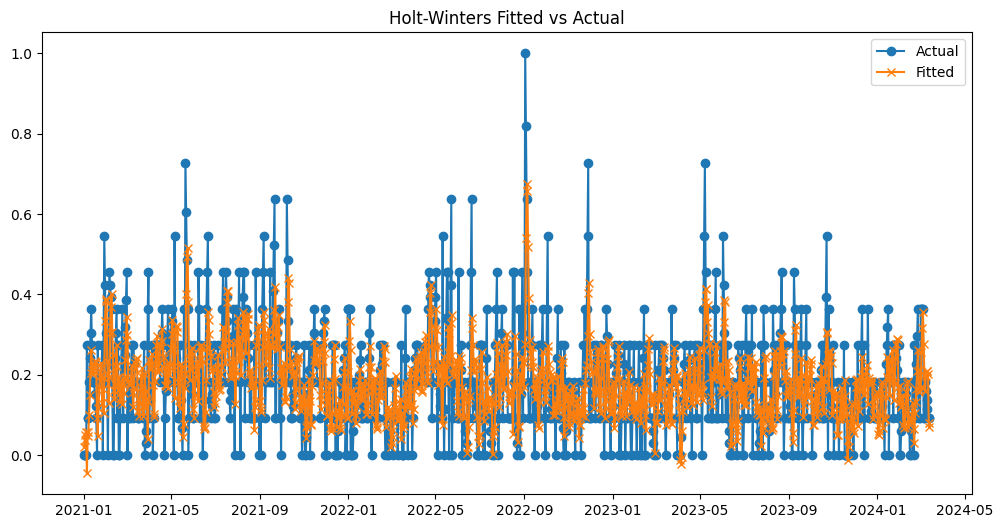

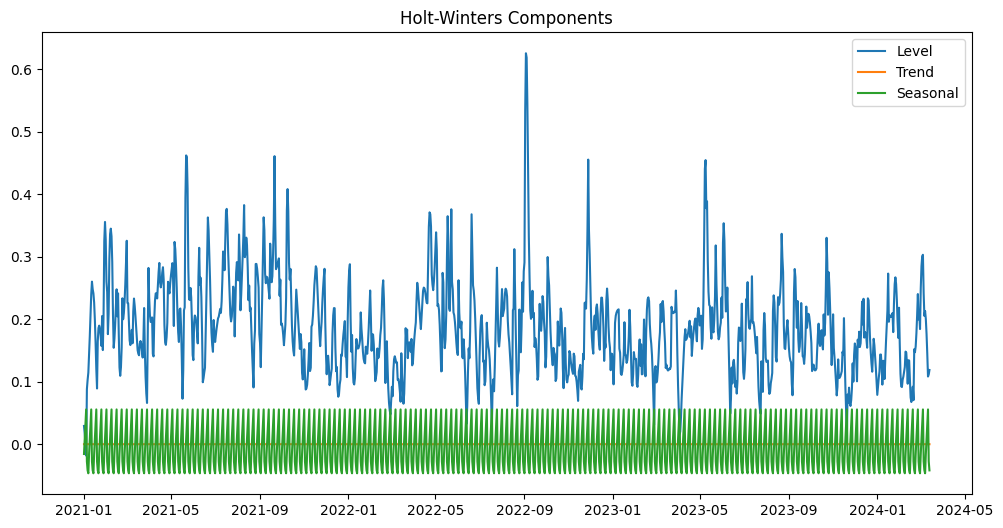

In [59]:
# Plot actual vs fitted values
plt.figure(figsize=(12,6))
plt.plot(train.index, train['scaled'], label='Actual', marker='o')
plt.plot(train.index, fit.fittedvalues, label='Fitted', marker='x')
plt.title('Holt-Winters Fitted vs Actual')
plt.legend()
plt.show()

# Plot components: level, trend, seasonal
plt.figure(figsize=(12,6))
plt.plot(fit.level, label='Level')
plt.plot(fit.trend, label='Trend')
plt.plot(fit.season, label='Seasonal')
plt.title('Holt-Winters Components')
plt.legend()
plt.show()

In [56]:
# Compare Actual vs Forecast

result = pd.DataFrame({
    "Actual": test_actual,
    "Forecast": forecast
}, index=test.index)
print(result.head(10))

              Actual  Forecast
date                          
2024-03-14  1.000000  1.796040
2024-03-15  2.000000  2.135911
2024-03-16  1.666667  2.398043
2024-03-17  1.333333  2.660189
2024-03-18  1.000000  2.922396
2024-03-19  2.000000  2.009368
2024-03-20  2.000000  1.851592
2024-03-21  2.000000  1.801496
2024-03-22  3.000000  2.141367
2024-03-23  3.000000  2.403499


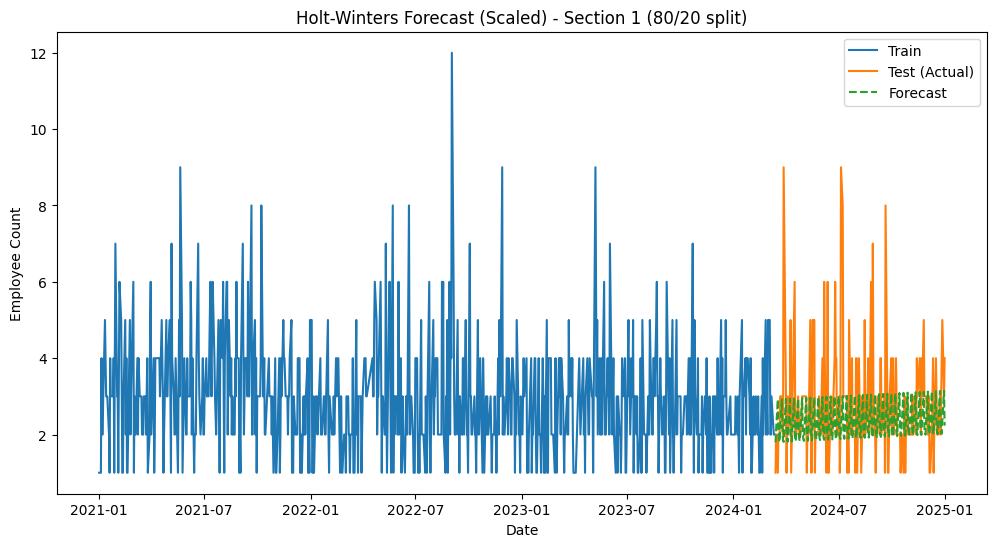

In [57]:
# Plot Results

plt.figure(figsize=(12,6))
plt.plot(train.index, scaler.inverse_transform(train['scaled'].values.reshape(-1, 1)), label="Train")
plt.plot(test.index, test_actual, label="Test (Actual)")
plt.plot(test.index, forecast, label="Forecast", linestyle="--")
plt.legend()
plt.title("Holt-Winters Forecast (Scaled) - Section 1 (80/20 split)")
plt.xlabel("Date")
plt.ylabel("Employee Count")
plt.show()